In [1]:
import optuna
import pickle
import torch
import os
import sys
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pandas as pd
from matplotlib.ticker import MultipleLocator
from scipy.optimize import linear_sum_assignment


# Add the root folder to Python path
root_folder = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_folder not in sys.path:
    sys.path.append(root_folder)

import lib.unet_nn as UNet
import lib.modified_aggregation as MA
from lib.modified_aggregation_clusterer import ModifiedAggregationClusterer
from lib.unet_clusterer import UNetClusterer
from lib.focal import FocalH
from lib.base_nn import Data
from lib import metrics# import count_clusters, count_labels, compute_score, total, separation_efficiency

os.chdir('/home/bjartur/workspace/python_focalh_clustering/') # Laptop and Desktop

# Study overview

# Evaluate studies

In [2]:
ma_study_file = "studies/best/study_ma_24082025_133543.pkl"

cnn_study_file = "studies/study_cnn_24082025_132142.pkl"
cnn_model_file = "studies/model_cnn_24082025_132142.pt"

# Analyse evaluation

In [4]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size" : 15,
    "legend.fontsize" : 12,
    "xtick.direction" : "in",
    "ytick.direction" : "in",
    "xtick.major.size" : 5.0,
    "xtick.minor.size" : 3.0,
    "ytick.major.size" : 5.0,
    "ytick.minor.size" : 3.0,
    "axes.linewidth" : 0.8,
    "legend.handlelength" : 2,
})

def plot_discrete(x,y,label=""):
    unq = np.unique(x)
    muy = np.zeros_like(unq)
    mux = np.zeros_like(unq)
    sigmay = np.zeros_like(unq)
    sigmax = np.zeros_like(unq)
    for i in range(len(unq)):
        mask = x == unq[i]
        muy[i] = y[mask].mean()
        mux[i] = x[mask].mean()
        sigmay[i] = y[mask].std()/np.sqrt(len(y[mask]))
        sigmax[i] = x[mask].std()/np.sqrt(len(x[mask]))

    plt.errorbar(mux,muy,sigmay,marker=".",linestyle="", label=label)
    plt.ylim(0,2)
    plt.legend()


def plot_performance_particle_num(df, x_col, y_col, marker_shape="^", linestyle="", color="", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    grp = df.groupby(x_col)[y_col]
    mu_x = grp.mean().index
    mu_y = grp.mean().values
    sigma_y = grp.sem().values
    if color == "":
        ax.errorbar(mu_x, mu_y, yerr=sigma_y, marker=marker_shape, linestyle=linestyle, capsize=5)
    else:
        ax.errorbar(mu_x, mu_y, yerr=sigma_y, marker=marker_shape, linestyle=linestyle, color=color, capsize=5)
    #ax.plot(mu_x, mu_y)


def plot_chunks(x, y, Nbins, label, marker_shape=".", color="", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    bins = np.linspace(min(x), max(x), Nbins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    mu_y = np.zeros(Nbins)
    sigma_y = np.zeros(Nbins)
    
    for i in range(Nbins):
        mask = (x >= bins[i]) & (x < bins[i+1])
        if np.any(mask):
            mu_y[i] = np.mean(y[mask])
            sigma_y[i] = np.std(y[mask]) / np.sqrt(np.sum(mask))

    if color == "":
        ax.errorbar(bin_centers, mu_y, yerr=sigma_y, marker=marker_shape, linestyle='solid', capsize=5)
    else:
        ax.errorbar(bin_centers, mu_y, yerr=sigma_y, marker=marker_shape, linestyle='solid', color=color, capsize=5)




def format_with_suffix(num):
    if num >= 1e9:
        return f"{num / 1e9:.1f}B"
    elif num >= 1e6:
        return f"{num / 1e6:.1f}M"
    elif num >= 1e3:
        return f"{num / 1e3:.1f}K"
    else:
        return str(num)


#plot_discrete(count, score)

In [5]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [41]:
#print(plt.rcParams['axes.prop_cycle'].by_key()['color'])
#['#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF']

evals = dict()
evals["ma_two"] = {
#    "file": "evaluation/eval_ma_two_15092025_130928.pkl",
    "file": "evaluation/eval_ma_eval_two_22092025_141310.pkl",
    "name": "Modified Aggregation",
    "name_short": "ma",
    "opt": "separation",
    "train": "tiny_single",
    "default_plot_color": "tab:blue",
    "default_plot_marker": "^"
}

evals["ma"] = {
#    "file": "evaluation/eval_ma_two_15092025_130928.pkl",
    "file": "evaluation/eval_ma_19102025_155349.pkl",
    "name": "Modified Aggregation",
    "name_short": "ma",
    "opt": "separation",
    "train": "tiny_single",
    "default_plot_color": "tab:blue",
    "default_plot_marker": "^"
}

evals["cnn_two"] = {
    "file": "evaluation/eval_cnn_eval_two_18092025_061219.pkl",
    "name": "CNN+Modified Aggregation",
    "name_short": "cnn",
    "opt": "separation",
    "train": "??",
    "default_plot_color": "tab:orange",
    "default_plot_marker": "s"
}

evals["kmeans_two"] = {
    "file": "evaluation/eval_kmeans_eval_two_18092025_055043.pkl",
    "name": "Oracle+Kmeans",
    "name_short": "kmeans",
    "opt": "separation",
    "train": "tiny_many",
    "default_plot_color": "tab:green",
    "default_plot_marker": "o"
}

evals["gauss_two"] = {
    "file": "evaluation/eval_gauss_eval_two_18092025_060817.pkl",
    "name": "Oracle+Gauss",
    "name_short": "gauss",
    "opt": "separation",
    "train": "tiny_many",
    "default_plot_color": "tab:red",
    "default_plot_marker": "1"
}


evals["hdbscan_many"] = {
    "file": "evaluation/eval_hdbscan_eval_two_18092025_094713.pkl",
    "name": "HDBSCAN",
    "name_short": "hdbscan",
    "opt": "separation",
    "train": "tiny_many",
    "default_plot_color": "tab:purple",
    "default_plot_marker": "p"
}

#hdbscan_eval_file = "evaluation/eval_hdbscan_eval_two_18092025_094713.pkl" # train_tiny
#dbscan_eval_file = "evaluation/eval_dbscan_08092025_162047.pkl"


for k,v in evals.items():
    with open(v["file"], "rb") as f:
        loaded_bundle = pickle.load(f)
    v["data"] = loaded_bundle



In [42]:
for key,value in evals["ma"]["data"].items():
    print(key)

method
study
data
its
timestamps
load_path
eval


In [43]:
mask = evals["ma"]["data"]["eval"]["particles"] == 2
evals["ma"]["data"]["eval"]["separation"][mask][:,0].sum() / evals["ma"]["data"]["eval"]["separation"][mask][:,1].sum()

np.float64(0.3533096326392416)

In [47]:
pairs = np.concatenate(evals["ma"]["data"]["eval"]["energy_pairs"])

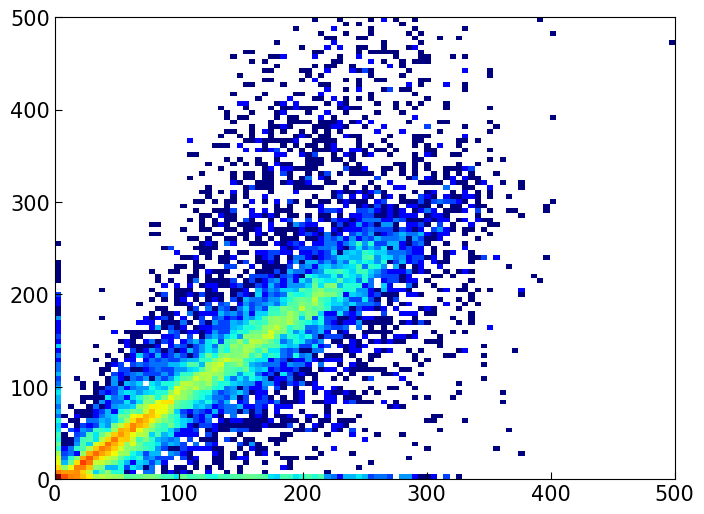

(-5.0, 400.0)

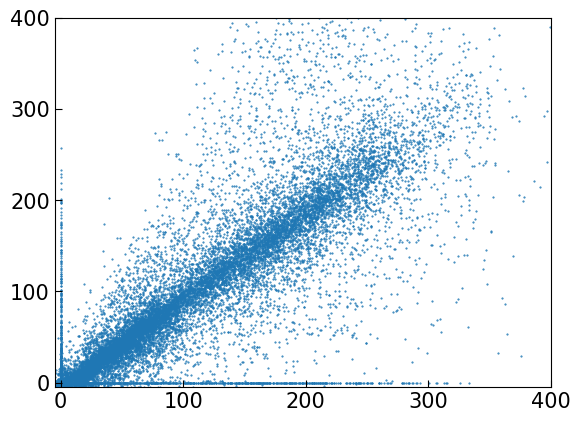

In [76]:
import matplotlib.colors as colors
bins = np.linspace(0, 500, 100)
migration_matrix, xedges, yedges = np.histogram2d(
    pairs[:,0], pairs[:,1], bins=[bins, bins]
)
plt.figure(figsize=(8, 6))
plt.imshow(
    migration_matrix.T,  # Transpose to match the orientation of true vs reconstructed
    origin="lower",
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect="auto",
    cmap="jet",
    norm=colors.LogNorm(),
)
plt.show()
plt.scatter(pairs[:,0], pairs[:,1], marker=".", s=1)
plt.xlim(-5,400)
plt.ylim(-5,400)

In [79]:
pairs[:,0].max()

np.float64(512.84375)

In [29]:
mask.shape

(1700,)

In [34]:
def dist(coms):
    dists = [None]*len(coms)
    for i in range(len(coms)):
        diff = coms[i][:, np.newaxis, :] - coms[i][np.newaxis, :, :]
        dist = np.sqrt((diff ** 2).sum(axis=-1))
        upper_tri = dist[np.triu_indices_from(dist, k=1)]
        dists[i] = upper_tri.mean()
    return dists

In [ ]:



fig,ax = plt.subplots()
plot_performance_particle_num(df_ma, "avg_energy", "efficiency", marker_shape="^", linestyle="dashed", ax=ax)
plot_performance_particle_num(df_cnn, "avg_energy", "efficiency", marker_shape="s", linestyle="dashed", ax=ax)
plot_performance_particle_num(df_hdbscan, "avg_energy", "efficiency", marker_shape="o", linestyle="dashed", ax=ax)
plot_performance_particle_num(df_dbscan, "avg_energy", "efficiency", marker_shape="o", linestyle="dashed", ax=ax)
#ax.set_xticks([1,2,3,4,5,6,7,8,9,10], ["1","2","3","4","5","6","7","8","9","10"])
ax.set_xticks([0,50,100,150,200,250,300,350], ["0","50","100","150","200","250","300","350"])
#ax.set_xticks([1,2], ["1","2"])
ax.set_ylim(0,3)
ax.xaxis.set_minor_locator(MultipleLocator(10))
#ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Efficiency [$N_{clusters}/N_{particles}$]")
ax.axhline(1, color="grey", linestyle="dotted")
ax.scatter([],[], label="Modified Aggregation", marker="^")
ax.scatter([],[], label="CNN+Modified Aggregation", marker="s")
ax.scatter([],[], label="HDBSCAN", marker="s")
ax.scatter([],[], label="DBSCAN", marker="s")
ax.legend(framealpha=0)

#ax.text(0.00, 1.05, "FoCal-H Prototype 2", transform=plt.gca().transAxes, ha="left", va="center")
#ax.text(1.00, 1.05, f"${len(df_ma):.0E}$ MC Events", transform=plt.gca().transAxes, ha="right", va="center")


ax.text(0.03, 0.93, "FoCal-H", transform=plt.gca().transAxes, ha="left", va="center")
ax.text(0.03, 0.86, "Prototype 2 Monte-Carlo", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.80, f"1-10 particles", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.74, f"{format_with_suffix(len(df_ma))} events", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)


#ax.grid(True)
fig.savefig("eval_eff_energy_many.png", bbox_inches="tight")

In [ ]:
ma_single = df_ma["particles"] == 1
cnn_single = df_cnn["particles"] == 1
hdbscan_single = df_hdbscan["particles"] == 1
dbscan_single = df_dbscan["particles"] == 1

fig,ax = plt.subplots()
plot_performance_particle_num(df_ma[ma_single], "avg_energy", "efficiency", marker_shape="^", linestyle="dashed", ax=ax)
plot_performance_particle_num(df_cnn[cnn_single], "avg_energy", "efficiency", marker_shape="s", linestyle="dashed", ax=ax)
plot_performance_particle_num(df_hdbscan[hdbscan_single], "avg_energy", "efficiency", marker_shape="o", linestyle="dashed", ax=ax)
plot_performance_particle_num(df_dbscan, "avg_energy", "efficiency", marker_shape="o", linestyle="dashed", ax=ax)
#ax.set_xticks([1,2,3,4,5,6,7,8,9,10], ["1","2","3","4","5","6","7","8","9","10"])
ax.set_xticks([0,50,100,150,200,250,300,350], ["0","50","100","150","200","250","300","350"])
#ax.set_xticks([1,2], ["1","2"])
ax.set_ylim(0,4)
ax.xaxis.set_minor_locator(MultipleLocator(10))
#ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Efficiency [$N_{clusters}/N_{particles}$]")
ax.axhline(1, color="grey", linestyle="dotted")
ax.scatter([],[], label="Modified Aggregation", marker="^")
ax.scatter([],[], label="CNN+Modified Aggregation", marker="s")
ax.scatter([],[], label="HDBSCAN", marker="o")
ax.scatter([],[], label="DBSCAN", marker="o")
ax.legend(framealpha=0)

ax.text(0.03, 0.93, "FoCal-H", transform=plt.gca().transAxes, ha="left", va="center")
ax.text(0.03, 0.86, "Prototype 2 Monte-Carlo", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.80, f"Single particles", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.74, f"{format_with_suffix(len(df_ma[ma_single]))} events", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)

fig.savefig("eval_eff_energy_single.png", bbox_inches="tight")

In [ ]:
fig,ax = plt.subplots()
plot_performance_particle_num(df_ma, "particles", "efficiency", marker_shape="^", linestyle="dashed", ax=ax)
plot_performance_particle_num(df_cnn, "particles", "efficiency", marker_shape="s", linestyle="dashed", ax=ax)
plot_performance_particle_num(df_hdbscan, "particles", "efficiency", marker_shape="o", linestyle="dashed", ax=ax)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10], ["1","2","3","4","5","6","7","8","9","10"])
#ax.set_xticks([0,50,100,150,200,250,300,350], ["0","50","100","150","200","250","300","350"])
#ax.set_xticks([1,2], ["1","2"])
ax.set_ylim(0,3)
ax.xaxis.set_minor_locator(MultipleLocator(10))
#ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.set_xlabel("Particles")
ax.set_ylabel("Efficiency [$N_{clusters}/N_{particles}$]")
ax.axhline(1, color="grey", linestyle="dotted")
ax.scatter([],[], label="Modified Aggregation", marker="^")
ax.scatter([],[], label="CNN+Modified Aggregation", marker="s")
ax.scatter([],[], label="HDBSCAN", marker="o")
ax.legend(framealpha=0)

#ax.text(0.00, 1.05, "FoCal-H Prototype 2", transform=plt.gca().transAxes, ha="left", va="center")
#ax.text(1.00, 1.05, f"${len(df_ma):.0E}$ MC Events", transform=plt.gca().transAxes, ha="right", va="center")

ax.text(0.03, 0.93, "FoCal-H", transform=plt.gca().transAxes, ha="left", va="center")
ax.text(0.03, 0.86, "Prototype 2 Monte-Carlo", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.80, f"Energy: 20-350 GeV", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.74, f"{format_with_suffix(len(df_ma[ma_single]))} events", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)



#ax.grid(True)
fig.savefig("eval_eff_particles.png", bbox_inches="tight")

In [ ]:
ma_two = df_ma["particles"] == 2
cnn_two = df_cnn["particles"] == 2
hdbscan_two = df_hdbscan["particles"] == 2
bins=10
fig,ax = plt.subplots()
#plot_performance_particle_num(df_ma[ma_two], "coms_dists", "vmeasure", marker_shape="^", linestyle="dashed", ax=ax)
plot_chunks(df_ma[ma_two]["coms_dists"], df_ma[ma_two]["efficiency"], bins, "Modified Aggregation", "o", "", ax)
plot_chunks(df_cnn[cnn_two]["coms_dists"], df_cnn[cnn_two]["efficiency"], bins, "CNN+Modified Aggregation", "o", "", ax)
plot_chunks(df_hdbscan[hdbscan_two]["coms_dists"], df_hdbscan[hdbscan_two]["efficiency"], bins, "HDBSCAN", "o", "", ax)

ax.set_xticks(
    [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
    ["0", "2", "4", "6", "8", "10", "12", "14", "16", "18", "20"])
ax.set_ylim(0,2)
ax.xaxis.set_minor_locator(MultipleLocator(1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.set_xlabel("Center-of-mass distance [cm]")
ax.set_ylabel("Efficiency [$N_{clusters}/N_{particles}$]")

ax.scatter([],[], label="Modified Aggregation", marker="^")
ax.scatter([],[], label="CNN+Modified Aggregation", marker="s")
ax.scatter([],[], label="HDBSCAN", marker="o")
ax.legend(framealpha=0)
ax.axhline(1, color="grey", linestyle="dotted")

ax.text(0.03, 0.93, "FoCal-H", transform=plt.gca().transAxes, ha="left", va="center")
ax.text(0.03, 0.86, "Prototype 2 Monte-Carlo", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.80, f"Energy: 20-350 GeV", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.74, f"2-particle events", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.68, f"{format_with_suffix(len(df_ma[ma_two]))} events", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)



fig.savefig("eval_eff_com.png", bbox_inches="tight")

# Separation

$$
\text{eff}_{\text{separation}} = \frac{N_{\text{abs}(E_{rec,true} - E_{rec,pred}) < \sigma_E}}{N_{objects}}
$$

Text(0.03, 0.74, 'Energy: 20-350 GeV')

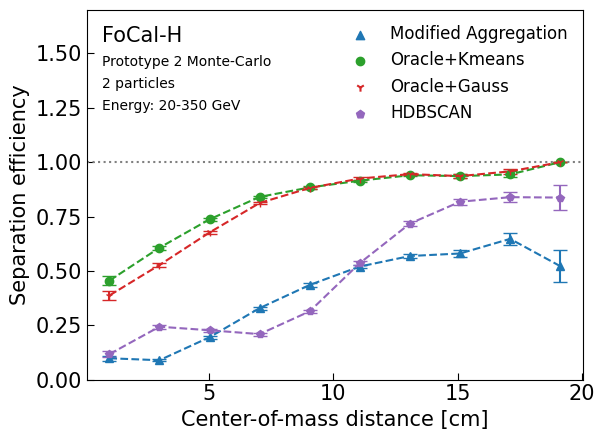

In [40]:
#lst = ["ma_two", "kmeans_two", "gauss_two", "hdbscan_many"] # keys in evals
lst = ["ma", "kmeans_two", "gauss_two", "hdbscan_many"] # keys in evals


def standard_error_of_proportion(p,n):
    return np.sqrt((p*(1-p))/n)

def plot_separation(df,Nbins,ax, marker_shape="^", linestyle="", color=""):
    x = dist(df["data"]["eval"]["coms"])
    bins = np.linspace(min(x), max(x), Nbins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    mu_y = np.zeros(Nbins)
    sigma_y = np.zeros(Nbins)
    y = df["data"]["eval"]["separation"]

    for i in range(Nbins):
        mask = (x >= bins[i]) & (x < bins[i+1])
        if np.any(mask):
            mu_y[i] = y[mask][:,0].sum() / y[mask][:,1].sum()
            sigma_y[i] = standard_error_of_proportion(mu_y[i], y[mask][:,1].sum())
    
    ax.errorbar(bin_centers, mu_y, yerr=sigma_y, marker = marker_shape, linestyle=linestyle, color=color, capsize=5)


fig,ax = plt.subplots()

Nbins=10

for l in lst:
    plot_separation(evals[l],Nbins, ax
                    , marker_shape=evals[l]["default_plot_marker"]
                    , linestyle="dashed"
                    , color=evals[l]["default_plot_color"]
                   )
    ax.scatter([],[], marker=evals[l]["default_plot_marker"]
               , color=evals[l]["default_plot_color"]
               , label=evals[l]["name"])


ax.axhline(1, color="grey", linestyle="dotted")

ax.set_ylim(0,1.7)

ax.legend(framealpha=0)
ax.set_xlabel("Center-of-mass distance [cm]")
ax.set_ylabel("Separation efficiency")

ax.text(0.03, 0.93, "FoCal-H", transform=plt.gca().transAxes, ha="left", va="center")
ax.text(0.03, 0.86, "Prototype 2 Monte-Carlo", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.80, f"2 particles", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.74, f"Energy: 20-350 GeV", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
#ax.text(0.03, 0.68, f"{format_with_suffix(len(df_ma))} events", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)

#fig.savefig("sep_eff.png", bbox_inches="tight")

In [103]:
df_kmeans[df_kmeans["efficiency"] != 1]
df_ma[df_ma["efficiency"] != 1]

,efficiency,vmeasure,coverage,particles,avg_energy,coms_dists,separation_resolved,separation_total
0,1.5,0.314463,0.958047,2.0,350.0,9.965072,1.0,3.0
1,2.0,0.329608,0.965891,2.0,350.0,11.337548,2.0,4.0
5,2.0,0.121110,0.916694,2.0,350.0,13.895787,1.0,4.0
6,1.5,0.275720,0.956859,2.0,350.0,11.569286,2.0,3.0
9,0.5,0.000120,0.948367,2.0,350.0,3.955612,0.0,2.0
...,...,...,...,...,...,...,...,...
9995,0.5,0.037704,0.692356,2.0,20.0,7.113160,1.0,2.0
9996,0.0,0.000000,0.000000,2.0,20.0,7.718409,0.0,2.0
9997,0.5,0.354640,0.431674,2.0,20.0,10.757240,1.0,2.0
9998,0.0,0.000000,0.000000,2.0,20.0,6.845216,0.0,2.0


In [11]:
def standard_error_of_proportion(p,n):
    return np.sqrt((p*(1-p))/n)

standard_error_of_proportion(0.157, 300)

np.float64(0.02100404722904612)

In [8]:
df_ma[two_mask]

,efficiency,vmeasure,coverage,particles,avg_energy,coms_dists,separation_resolved,separation_total
0,1.5,0.314463,0.958047,2.0,350.0,9.965072,1.0,3.0
1,2.0,0.329608,0.965891,2.0,350.0,11.337548,2.0,4.0
2,1.0,0.225252,0.974559,2.0,350.0,7.962064,2.0,2.0
3,1.0,0.139240,0.947421,2.0,350.0,6.031273,2.0,2.0
4,1.0,0.214546,0.942637,2.0,350.0,15.162154,2.0,2.0
...,...,...,...,...,...,...,...,...
9995,0.5,0.037704,0.692356,2.0,20.0,7.113160,1.0,2.0
9996,0.0,0.000000,0.000000,2.0,20.0,7.718409,0.0,2.0
9997,0.5,0.354640,0.431674,2.0,20.0,10.757240,1.0,2.0
9998,0.0,0.000000,0.000000,2.0,20.0,6.845216,0.0,2.0


In [ ]:
df_cnn[cnn_two]

In [ ]:
from plotly.io import show

In [ ]:
print(ma_eval["study"].best_params)
fig = optuna.visualization.plot_param_importances(ma_eval["study"])
show(fig)

In [ ]:
fig = optuna.visualization.plot_optimization_history(cnn_eval["study"]["study"])
show(fig)